### 1. (a)

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.random.seed(42)

In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
splits = []
for i in range(4):
    df_train, df_test = train_test_split(df, test_size=(0.5 - (0.1 * i)), random_state=42)
    df_test, df_val = train_test_split(df_test, test_size=(1.0 / (5 - i)))
    splits.append([df_train, df_val, df_test])
splits[3][1].head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
23,9,119,80,35,0,29.0,0.263,29,1
250,9,106,52,0,0,31.2,0.380,42,0
470,1,144,82,40,0,41.3,0.607,28,0
716,3,173,78,39,185,33.8,0.970,31,1
579,2,197,70,99,0,34.7,0.575,62,1


In [14]:
# eda
print(splits[0][0].shape)
print(splits[0][1].shape)
print(splits[0][2].shape)

(384, 9)
(77, 9)
(307, 9)


### 1. (b)

In [105]:
def standardize(train_df, val_df, test_df, target_col="Outcome"):
    X_train = train_df.drop(target_col, axis=1).to_numpy()
    mu = X_train.mean(axis=0)
    sigma = X_train.std(axis=0)
    sigma[sigma == 0] = 1.0
    def tr(df):
        X = (df.drop(target_col, axis=1).to_numpy() - mu)/sigma
        y = df[target_col].to_numpy()
        return X.T, y.reshape(1, -1)
    return *tr(train_df), *tr(val_df), *tr(test_df)

In [ ]:
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

def initialize_with_zeros(dim):
    return np.zeros((dim, 1)), 0.0

def compute_cost(A, Y):
    m = Y.shape[1]
    eps = 1e-12
    return - (np.sum(Y * np.log(A + eps) + (1 - Y) * np.log(1 - A + eps))) / m

def forward(w, b, X):
    return sigmoid(np.dot(w.T, X) + b)

def propagate(w, b, X, Y):
    A = forward(w, b, X)
    cost = compute_cost(A, Y)
    m = X.shape[1]
    dw = (np.dot(X, (A - Y).T)) / m
    db = np.sum(A - Y) / m
    return {"dw": dw, "db": db}, cost

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate, stopping_param, print_cost=False):
    costs = []
    last_cost = None
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        w -= learning_rate * grads["dw"]
        b -= learning_rate * grads["db"]
        costs.append(cost)
        if print_cost and i % 10 == 0:
            print(f"Iter {i} cost {cost:.4f}")
        if last_cost is not None and abs(last_cost - cost) < stopping_param:
            break
        last_cost = cost
    return {"w": w, "b": b}, grads, costs


In [108]:
alphas = [0.0001, 0.1]
rhos = [0.001, 0.01]
epochs = [50, 100]

results = []
split_specs = [(0.5, "50_10_40"), (0.6, "60_10_30"), (0.7, "70_10_20"), (0.8, "80_10_10")]

for split, tag in zip(splits, [s[1] for s in split_specs]):
    df_train, df_val, df_test = split
    X_train, Y_train, X_val, Y_val, X_test, Y_test = standardize(df_train, df_val, df_test)
    dim = X_train.shape[0]
    for alpha in alphas:
        for rho in rhos:
            for epoch in epochs:
                w, b = initialize_with_zeros(dim)
                params, grads, costs = optimize(w, b, X_train, Y_train, epoch, alpha, rho, print_cost=True)
                w, b = params["w"], params["b"]
                # validation accuracy
                def predict_prob(w, b, X): return forward(w, b, X)
                def predict_cls(w, b, X): return (predict_prob(w, b, X) > 0.5).astype(int)
                val_acc = 100 - np.mean(np.abs(predict_cls(w, b, X_val) - Y_val)) * 100
                train_acc = 100 - np.mean(np.abs(predict_cls(w, b, X_train) - Y_train)) * 100
                results.append({
                    "split_tag": tag,
                    "w": w, "b": b, "costs": costs,
                    "alpha": alpha, "rho": rho, "epoch": epoch,
                    "val_acc": val_acc, "train_acc": train_acc,
                    "X_test": X_test, "Y_test": Y_test
                })
                print()


Cost after iteration 0: 0.693147
Cost after iteration 10: 0.693011
Early stopping at iteration 10.

Cost after iteration 0: 0.693147
Cost after iteration 10: 0.693011
Early stopping at iteration 10.

Cost after iteration 0: 0.693147
Cost after iteration 10: 0.693011
Early stopping at iteration 10.

Cost after iteration 0: 0.693147
Cost after iteration 10: 0.693011
Early stopping at iteration 10.

Cost after iteration 0: 0.693147
Cost after iteration 10: 0.598929
Cost after iteration 20: 0.554231
Cost after iteration 30: 0.529617
Cost after iteration 40: 0.514470

Cost after iteration 0: 0.693147
Cost after iteration 10: 0.598929
Cost after iteration 20: 0.554231
Cost after iteration 30: 0.529617
Cost after iteration 40: 0.514470
Cost after iteration 50: 0.504413
Cost after iteration 60: 0.497377
Early stopping at iteration 67.

Cost after iteration 0: 0.693147
Cost after iteration 10: 0.598929
Early stopping at iteration 12.

Cost after iteration 0: 0.693147
Cost after iteration 10: 0.

In [112]:
best_per_split = {}
for r in results:
    tag = r["split_tag"]
    if tag not in best_per_split or r["val_acc"] > best_per_split[tag]["val_acc"]:
        best_per_split[tag] = r

print("Best models (by validation accuracy):")
for tag, r in best_per_split.items():
    Y_pred_test = (forward(r["w"], r["b"], r["X_test"]) > 0.5).astype(int)
    test_acc = 100 - np.mean(np.abs(Y_pred_test - r["Y_test"])) * 100
    r["test_acc"] = test_acc
    print(f"{tag}: val_acc={r['val_acc']:.2f} train_acc={r['train_acc']:.2f} test_acc={test_acc:.2f} alpha={r['alpha']} rho={r['rho']} epoch={r['epoch']} cost_final={r['costs'][-1]:.4f}")


Best models (by validation accuracy):
50_10_40: val_acc=71.43 train_acc=75.78 test_acc=79.15 alpha=0.1 rho=0.001 epoch=50 cost_final=0.5053
60_10_30: val_acc=74.03 train_acc=75.87 test_acc=75.76 alpha=0.1 rho=0.001 epoch=50 cost_final=0.5073
70_10_20: val_acc=74.03 train_acc=75.61 test_acc=69.48 alpha=0.0001 rho=0.001 epoch=50 cost_final=0.6930
80_10_10: val_acc=76.62 train_acc=75.08 test_acc=64.94 alpha=0.0001 rho=0.001 epoch=50 cost_final=0.6930


### 1. (c)

In [109]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T, X) + b)
    for i in range(A.shape[1]):
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0    
    assert(Y_prediction.shape == (1, m))
    return Y_prediction

In [115]:
for result in results:
    split_tag = result["split_tag"]
    pct = split_tag[0]
    alpha = result["alpha"]
    rho = result["rho"]
    epoch = result["epoch"]

    train_acc = result["train_acc"]
    val_acc = result["val_acc"]

    print(f"pct = {pct}, epochs = {epoch}, alpha = {alpha}, rho = {rho}")
    print(f"train_acc = {train_acc}, val_acc = {val_acc}")
    print()

pct = 5, epochs = 50, alpha = 0.0001, rho = 0.001
train_acc = 73.95833333333333, val_acc = 67.53246753246754

pct = 5, epochs = 100, alpha = 0.0001, rho = 0.001
train_acc = 73.95833333333333, val_acc = 67.53246753246754

pct = 5, epochs = 50, alpha = 0.0001, rho = 0.01
train_acc = 73.95833333333333, val_acc = 67.53246753246754

pct = 5, epochs = 100, alpha = 0.0001, rho = 0.01
train_acc = 73.95833333333333, val_acc = 67.53246753246754

pct = 5, epochs = 50, alpha = 0.1, rho = 0.001
train_acc = 75.78125, val_acc = 71.42857142857143

pct = 5, epochs = 100, alpha = 0.1, rho = 0.001
train_acc = 74.73958333333333, val_acc = 71.42857142857143

pct = 5, epochs = 50, alpha = 0.1, rho = 0.01
train_acc = 73.95833333333333, val_acc = 70.12987012987013

pct = 5, epochs = 100, alpha = 0.1, rho = 0.01
train_acc = 73.95833333333333, val_acc = 70.12987012987013

pct = 6, epochs = 50, alpha = 0.0001, rho = 0.001
train_acc = 73.69565217391305, val_acc = 70.12987012987013

pct = 6, epochs = 100, alpha = 

### 1. (d)

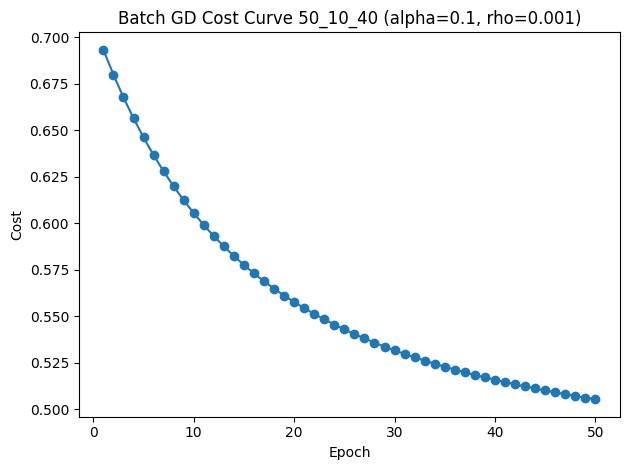

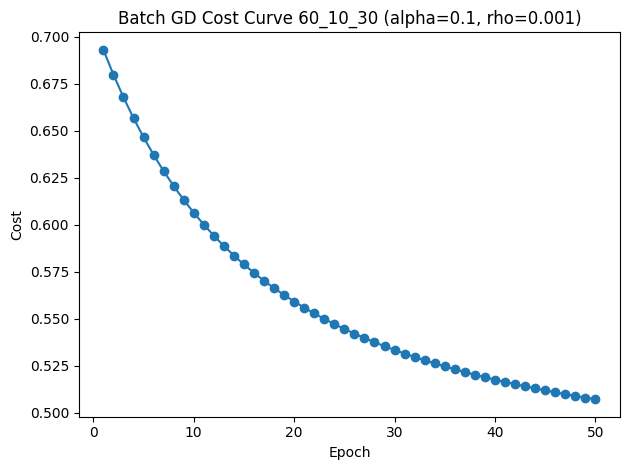

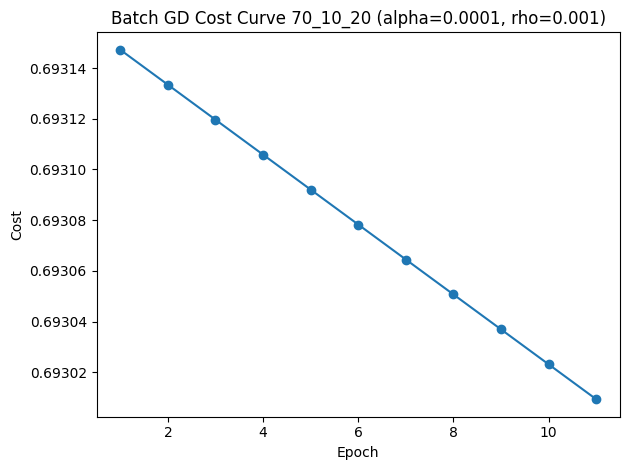

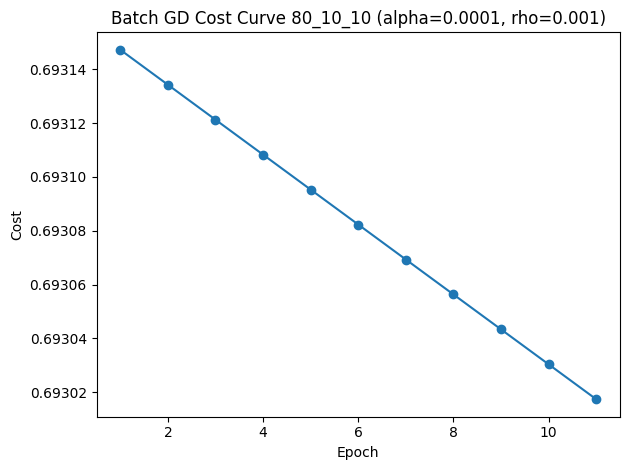

In [114]:
PLOTSDIR = "plots/"
import os
os.makedirs(PLOTSDIR, exist_ok=True)

for tag, r in best_per_split.items():
    plt.figure()
    plt.plot(range(1, len(r["costs"]) + 1), r["costs"], marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Cost")
    plt.title(f"Batch GD Cost Curve {tag} (alpha={r['alpha']}, rho={r['rho']})")
    plt.tight_layout()
    plt.savefig(f"{PLOTSDIR}batch_cost_{tag}.png")
    plt.show()


### 2.

In [116]:
def sgd_train(X, Y, epochs, alpha, rho, shuffle=True):
    m = X.shape[1]
    w, b = initialize_with_zeros(X.shape[0])
    costs = []
    last_cost = None
    for ep in range(epochs):
        indices = np.arange(m)
        if shuffle:
            np.random.shuffle(indices)
        for idx in indices:
            x_i = X[:, idx:idx+1]
            y_i = Y[:, idx:idx+1]
            A = forward(w, b, x_i)
            dw = (x_i * (A - y_i))
            db = (A - y_i).item()
            w -= alpha * dw
            b -= alpha * db
        A_full = forward(w, b, X)
        cost = compute_cost(A_full, Y)
        costs.append(cost)
        if last_cost is not None and abs(last_cost - cost) < rho:
            break
        last_cost = cost
    return {"w": w, "b": b, "costs": costs}

sgd_results = []
for split, tag in zip(splits, [s[1] for s in split_specs]):
    df_train, df_val, df_test = split
    X_train, Y_train, X_val, Y_val, X_test, Y_test = standardize(df_train, df_val, df_test)
    for alpha in alphas:
        for rho in rhos:
            for epoch in epochs:
                model = sgd_train(X_train, Y_train, epoch, alpha, rho)
                w, b = model["w"], model["b"]
                val_acc = 100 - np.mean(np.abs((forward(w, b, X_val) > 0.5).astype(int) - Y_val)) * 100
                train_acc = 100 - np.mean(np.abs((forward(w, b, X_train) > 0.5).astype(int) - Y_train)) * 100
                sgd_results.append({
                    "split_tag": tag, "w": w, "b": b, "costs": model["costs"],
                    "alpha": alpha, "rho": rho, "epoch": epoch,
                    "val_acc": val_acc, "train_acc": train_acc,
                    "X_test": X_test, "Y_test": Y_test
                })

sgd_best = {}
for r in sgd_results:
    tag = r["split_tag"]
    if tag not in sgd_best or r["val_acc"] > sgd_best[tag]["val_acc"]:
        sgd_best[tag] = r

print("Best SGD models:")
for tag, r in sgd_best.items():
    test_acc = 100 - np.mean(np.abs((forward(r["w"], r["b"], r["X_test"]) > 0.5).astype(int) - r["Y_test"])) * 100
    r["test_acc"] = test_acc
    print(f"{tag}: val_acc={r['val_acc']:.2f} train_acc={r['train_acc']:.2f} test_acc={test_acc:.2f} alpha={r['alpha']} rho={r['rho']} epoch={r['epoch']} final_cost={r['costs'][-1]:.4f}")

Best SGD models:
50_10_40: val_acc=71.43 train_acc=76.56 test_acc=78.50 alpha=0.1 rho=0.001 epoch=100 final_cost=0.4940
60_10_30: val_acc=76.62 train_acc=78.48 test_acc=76.62 alpha=0.1 rho=0.01 epoch=100 final_cost=0.5096
70_10_20: val_acc=79.22 train_acc=78.03 test_acc=73.38 alpha=0.1 rho=0.001 epoch=100 final_cost=0.4827
80_10_10: val_acc=80.52 train_acc=76.22 test_acc=74.03 alpha=0.1 rho=0.01 epoch=50 final_cost=0.4889


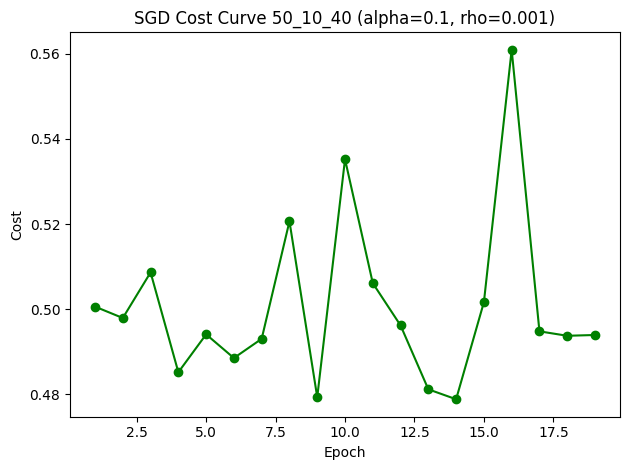

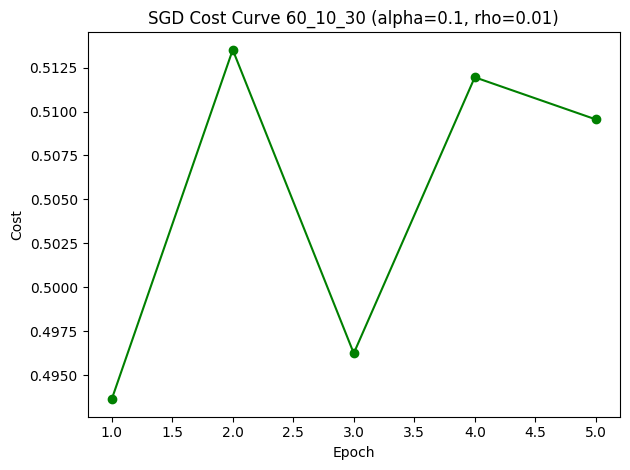

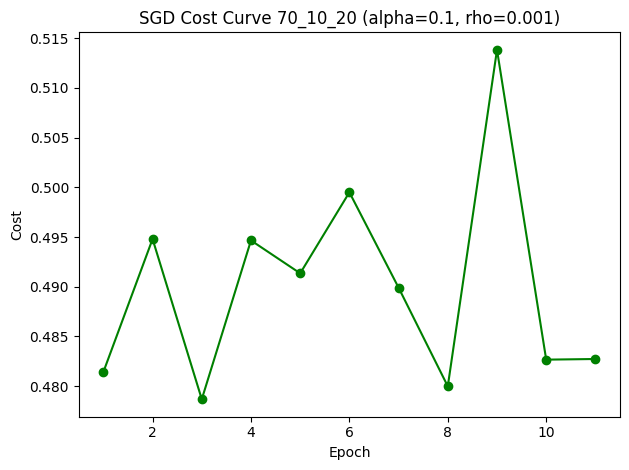

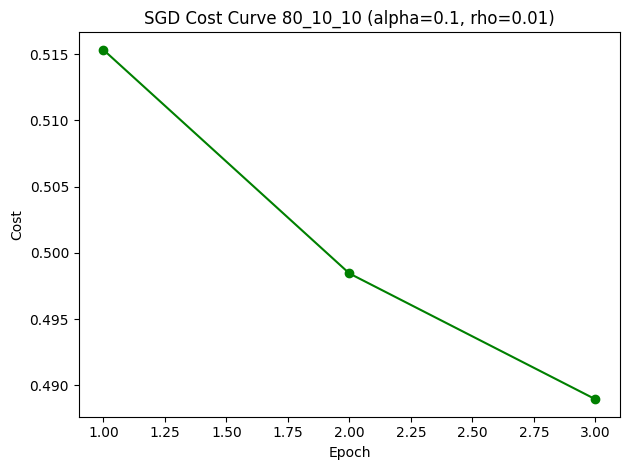

In [118]:
for tag, r in sgd_best.items():
    plt.figure()
    plt.plot(range(1, len(r["costs"]) + 1), r["costs"], marker='o', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Cost")
    plt.title(f"SGD Cost Curve {tag} (alpha={r['alpha']}, rho={r['rho']})")
    plt.tight_layout()
    plt.savefig(f"{PLOTSDIR}sgd_cost_{tag}.png")
    plt.show()